<h1 align="center"> <a href="https://engmrk.com/lenet-5-a-classic-cnn-architecture/"> Lenet300-100</a></h1>
The architecture is as follows (for bayesian NN simply double the number of parameters):
<img src="architectures/lenet300_100.png" width=600 height=600 />

For Bayesian Neural Network, we followed the implementation that was proposed by the following papers:
<ol>
<li> Kingma, Diederik P., Tim Salimans, and Max Welling. "Variational dropout and the local reparameterization trick." NIPS (2015). </li>
<li> Molchanov, Dmitry, Arsenii Ashukha, and Dmitry Vetrov. "Variational Dropout Sparsifies Deep Neural Networks." ICML (2017). </li>
<li> Louizos, Christos, Karen Ullrich, and Max Welling. "Bayesian Compression for Deep Learning." NIPS (2017).</li>
</ol>
<p> The KL divergence was implemented according to [3] Eq.(8), while the approximation of KL was performed based on [2] Eq.(14)</p>

2020-10-05 12:59:20 

<font size="3" color="blue"><b> Exprimental Setting for Bayesian NN </b></font>
    <li><b>Batch size</b>: 100</li>
    <li><b>KL scaling factor: </b>$\frac{1}{\#SamplesPerRound}$. This is according to [3]</li>
    <li><b>Retraining Methodology:</b> Unlike the CVPR paper, <b>we do not retrain from scratch</b>. We found that this method is mostly <b>detrimental to the performance </b> of all models (Both Bayesian and Non-bayesian). At each round, we simply re-use the previous weights, and train the model for a significantly less number of epoch. More precisely, We allot 10% of the training data as validation set and use an early stopping technique, to get the best parameters based on this validation set.</li>
    <li><b>Number of MCMC samples</b>: 1 <b>Note:</b>Since we have a closed form solution, we don't do MCMC to approximate KL. This significantly speeds up the execution time.</li>
    <li><b>Optimization Algorithm</b>: Adam</li>
    <li><b>Number of NN instantiations</b>: 25. That is, when performing active learning, we create 25 instantiations of NN with dropout and estimate variation-ratio and entropy.</li>
    
    
<font size="3" color="blue"><b> Exprimental Setting for Dropout neural network (NN)</b></font>
<li><b>Batch Size</b>: 32</li>
<li> <b>Dropout Rate</b>: 0.5 (default in pytorch)</li>
<li><b>Retraining Methodology:</b> Unlike the CVPR paper, <b>we do not retrain from scratch</b>. We found that this method is mostly <b>detrimental to the performance </b> of all models (Both Bayesian and Non-bayesian). At each round, we simply re-use the previous weights, and train the model for a significantly less number of epoch. More precisely, We allot 10% of the training data as validation set and use an early stopping technique, to get the best parameters based on this validation set.</li>
<li><b>Optimization Algorithm</b>: Adam</li>
<li><b>Number of NN instantiations</b>: 25. That is, when performing active learning, we create 25 instantiations of NN with dropout and estimate variation-ratio and entropy.</li>
The legend used in the graph are as follows:
AL stands for <u>a</u>ctive <u>l</u>earning with dropout-based neural network, <font color="blue">AL-VR</font> stands for <b><u>a</u>ctive <u>l</u>earning using <u>v</u>ariation-<u>r</u>atio</b>, <font color="blue">AL-E</font> stands for <u>a</u>ctive <u>l</u>earning using <u>E</u>ntropy, RS stands for <u>r</u>andom <u>s</u>ampling, legends with the character <font color="blue">B</font> in front of them are the Bayesian couter parts of the variational-ratio and entropy active-learning algorithms respectively.

</p>

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
# import mpld3
from matplotlib import rc
import numpy as np
import pandas as pd
import os
import pdb
# supposed to help make graphs interactive, to zoom in, but does not work
# mpld3.enable_notebook()

In [36]:
plot_pth = 'McDropoutVsBayesianVariationRatio/'
class getMetric:

    def __init__(self, typ, pth, truncate_end, truncate_st, n_classes):
        self.files = [f for f in os.listdir(pth)]
        self.files = sorted(self.files, key=lambda x: int(x.split('round')[1].split('.csv')[0]))
        if typ == 'accuracy' and n_classes == 10:
            indx = 'accuracy'
        elif typ == 'accuracy' and n_classes == 100:
            indx = 'accuracy'
        elif typ == 'r2':
            indx = 'r2'
        elif typ == 'ece':
            indx = 'ece'
        elif typ == 'ece_calibrated':
            indx = 'ece_calibrated'
        # classification error
        if truncate_end == None:
            self.metric = [pd.read_csv(pth + f, index_col=0).loc[indx][0] for f in self.files][:40]
        else:
            if not truncate_st: truncate_st = 0
            self.metric = [pd.read_csv(pth + f, index_col=0).loc[indx][0] for f in self.files][truncate_st:truncate_end]

def PlotGraph(figure_nam,data_locs,labels,truncate_end=None,truncate_st=None, x_l=None,y_l=None,
              n_classes=10,isample=100, mini_window=False, mini_window_range=(0,15),
              n_legen_clmns=1, metric='accuracy'):
    metric_list = [getMetric(metric,pth,truncate_end, truncate_st, n_classes).metric for pth in data_locs]
    rounds = range(len(metric_list[0]))
    if mini_window:
        start, end = mini_window_range[0], mini_window_range[1]
        mini_window_metric = [getMetric('accuracy',pth, end, start, n_classes).metric for pth in data_locs]
        rounds_mini_window = range(start, end)
    colors = ['#9B59B6','#76D7C4','#F5B041','#E74C3C','#2C3E50', '#3498DB', '#B2BABB', '#229954', '#F9E79F ']
    model_names = {'b_names':{'EN':['EN-VR','EN-E','EN-RS'],\
                              'Jeffrey':['BCN-VR', 'BCN-RS','BCN-E', 'BCN-VR*', 'BCN-E*']}}
    y_axis_names = {"accuracy":"Classification Accuracy","ece":"Expected Caliberation Error", 
                    "r2": "R-squared (R$^2$)" }
    # create specific colors and markers
    markers, line_style = [], []
    for l in labels:
        if l in model_names['b_names']['EN']:
            markers.append('^')
            line_style.append('--')
        elif l in model_names['b_names']['Jeffrey']:
            markers.append('X')
            line_style.append('--')
        else:
            markers.append('o')
            line_style.append('-')

    font = {'family': 'Serif',
            'weight': 'normal',
            'size': 25}
    rc('font', **font)
    if not figure_nam:
        figure_nam = 'my_fig.png'
    fig = plt.figure(num=1, figsize=(14, 7))
    ax = plt.axes()
    if mini_window:
        axins = ax.inset_axes([0.3, 0.1, 0.45, 0.4])
    for i,m in enumerate(metric_list):
        ax.plot(rounds, m, marker=markers[i], linestyle=line_style[i], color=colors[i], label=labels[i])
        if mini_window:
            axins.plot(rounds_mini_window, mini_window_metric[i], \
                       marker=markers[i], linestyle=line_style[i], color=colors[i], label=labels[i])
            axins.tick_params(axis="x", labelsize=12)
            axins.tick_params(axis="y", labelsize=12)
            
    if x_l:
        ax.set_xlim(x_l)
    if y_l:
        ax.set_ylim(y_l)

    ax.set_ylabel(y_axis_names[metric])
    ax.set_xlabel(r'# Samples ($\times ' + str(isample) + '$)')
    ax.legend(loc=4, ncol=n_legen_clmns, frameon=True, prop={'size': 18})
    if mini_window: ax.indicate_inset_zoom(axins)
    plt.savefig(plot_pth+figure_nam, orientation='portrait', bbox_inches='tight', dpi=300)

def bar_plot(data_locs, metric, calib_ece_loc, x_tick_labels,x_label, y_label,
             legend_names, figure_nam, truncate_end, truncate_st=None, n_legen_clmns=1, n_classes=10):

    # separate the files that indicate the caliberated ece
    calib_ece_loc = [data_locs.pop(calib_ece_loc)]
    metrics = [getMetric(metric, pth, truncate_end, truncate_st, n_classes).metric for pth in data_locs]
    tmp_metric = [getMetric("ece_calibrated", pth, truncate_end, truncate_st, n_classes).metric for pth in calib_ece_loc]
    metrics += tmp_metric
    # select rounds nums corresponding to 25%, 50% and 100%
    rnd_nums = [int(0.25*truncate_end), int(0.50*truncate_end), truncate_end-1]
    truncated_metrics = []
    for m in metrics:
        selected_metric = []
        for rnd in rnd_nums:
            selected_metric.append(m[rnd])
        truncated_metrics.append(selected_metric)
    font = {'family' : 'Serif',
        'weight' : 'normal',
        'size'   : 25}
    rc('font', **font)
    colors = ['#9B59B6','#F5B041','#2C3E50', '#A9CCE3']

    plt.figure(num=1,figsize=(14,7))
    ind = np.arange(len(truncated_metrics[0]))  # the x locations for the groups
    width = 0.2       # the width of the bars

    for i, vals in enumerate(truncated_metrics):
        shift = width * i
        plt.bar(ind+shift, vals, width, color=colors[i], label=legend_names[i], edgecolor='black')

     # add some text for labels, title and axes ticks
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.xticks(ind+width*2,x_tick_labels)
    plt.legend(ncol=n_legen_clmns,loc='best', prop={'size': 18}, frameon=True)
    plt.savefig(plot_pth+figure_nam, orientation='portrait', bbox_inches='tight', dpi=300)

<h2 align="center">MNIST data</h2>

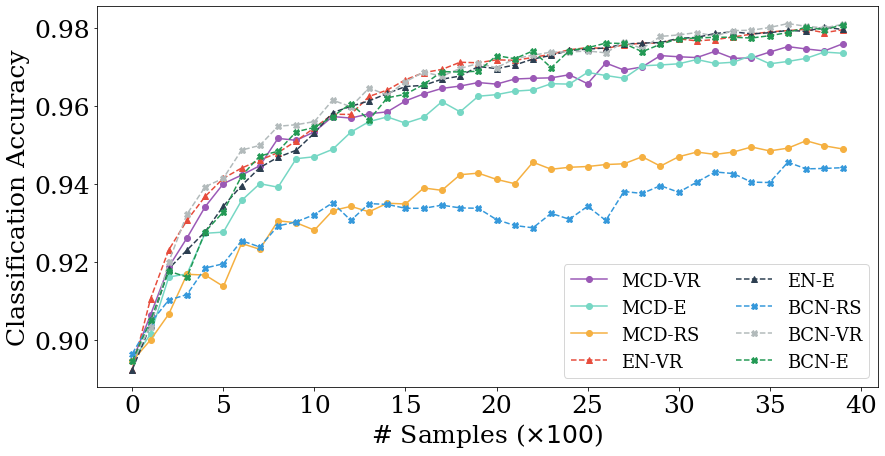

In [24]:
# 2020-10-26 09:45:19   1000 initial samples, re-run random sampling for bayesian, get random for ensemble
pth_1 = '../results_archive/McDropout/lenet300-100_mnist_isample1000_e50_r40_ac1_optim-Adam_top-k100_b32_rtAfter40_variation-ratio/'
pth_2 = '../results_archive/McDropout/lenet300-100_mnist_isample1000_e50_r40_ac1_optim-Adam_top-k100_b32_rtAfter40_entropy/'
pth_3 = '../results_archive/McDropout/lenet300-100_mnist_isample1000_e50_r40_ac0_optim-Adam_top-k100_b32_rtAfter40/'
# EN
pth_4 = '../results_archive/McDropout/ensemble/lenet300-100_mnist_isample1000_e50_activInstances5_r41_ac1_optim-Adam_top-k100_b32_rtAfter100_variation-ratio/'
pth_5 = '../results_archive/McDropout/ensemble/lenet300-100_mnist_isample1000_e50_activInstances5_r41_ac1_optim-Adam_top-k100_b32_rtAfter100_entropy/'
# BCN
pth_6 = '../results_archive/Blenet300-100_mnist_isample1000_e50_r41_ac0_Klreg-standard1_b100_topK-100_mcmc5_netType-blundelloptim-Adamvariation-ratio_rtAfter100/'
pth_7 = '../results_archive/Blenet300-100_mnist_isample1000_e50_r41_ac1_Klreg-standard2_b100_topK-100_mcmc1_netType-jeffreyoptim-Adam_variation-ratio_rtAfter0/'
pth_8 = '../results_archive/Blenet300-100_mnist_isample1000_e50_r41_ac1_Klreg-standard2_b100_topK-100_mcmc1_netType-jeffreyoptim-Adam_entropy_rtAfter0/'


locs = [pth_1, pth_2, pth_3, pth_4, pth_5, pth_6, pth_7, pth_8]
labels = ['MCD-VR','MCD-E', 'MCD-RS', "EN-VR","EN-E", 'BCN-RS', 'BCN-VR','BCN-E']
f_name = 'fig_a_v2'
PlotGraph(f_name,locs,labels, isample=100)

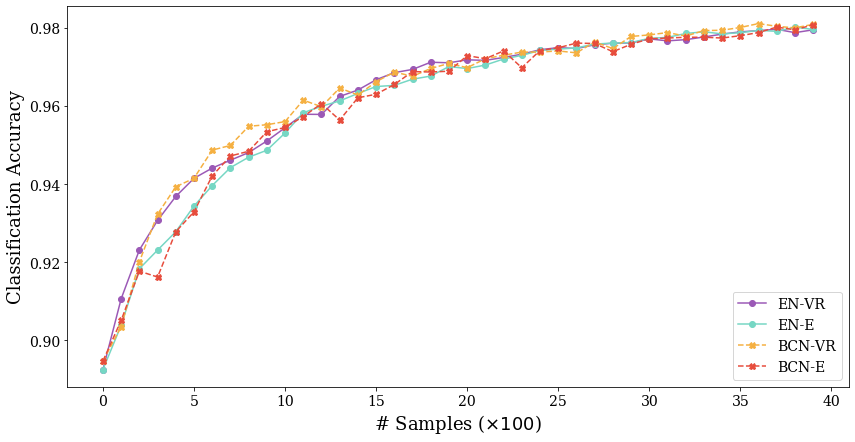

In [40]:
# 2020-05-20 23:26:01  1000 initial samples with just 5 NN as active learning instances (for BCN)
pth_1 = '../results_archive/McDropout/ensemble/lenet300-100_mnist_isample1000_e50_activInstances5_r41_ac1_optim-Adam_top-k100_b32_rtAfter100_variation-ratio/'
pth_2 = '../results_archive/McDropout/ensemble/lenet300-100_mnist_isample1000_e50_activInstances5_r41_ac1_optim-Adam_top-k100_b32_rtAfter100_entropy/'
pth_3 = '../results_archive/Blenet300-100_mnist_isample1000_e50_r41_ac1_Klreg-standard2_b100_topK-100_mcmc1_netType-jeffreyoptim-Adam_variation-ratio_rtAfter0/'
pth_4 = '../results_archive/Blenet300-100_mnist_isample1000_e50_r41_ac1_Klreg-standard2_b100_topK-100_mcmc1_netType-jeffreyoptim-Adam_entropy_rtAfter0/'

locs = [pth_1, pth_2, pth_3, pth_4]
labels = ["EN-VR","EN-E",'BCN-VR','BCN-E']
f_name = 'fig_c'
PlotGraph(f_name,locs,labels, isample=100)

2020-05-01 15:41:26 
<h2 align="center">Fashion MNIST data</h2>
All setting are similar to that of MNIST data, except for the number of McMc samples. Here we increase 

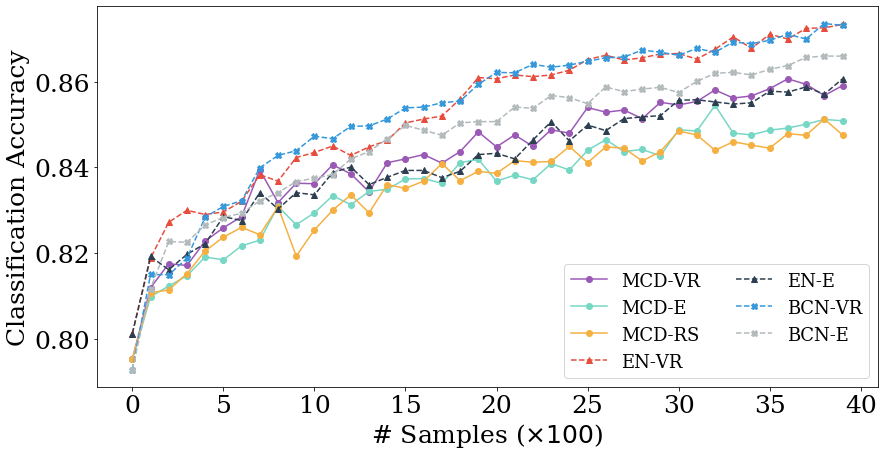

In [29]:
# 2020-10-26 09:59:58 1000 initial samples -- need random for bayesian and EN
# MCD
pth_1 = '../results_archive/McDropout/lenet300-100_fmnist_isample1000_e50_r40_ac1_optim-Adam_top-k100_b32_rtAfter40_variation-ratio/'
pth_2 = '../results_archive/McDropout/lenet300-100_fmnist_isample1000_e50_r40_ac1_optim-Adam_top-k100_b32_rtAfter40_entropy/'
pth_3 = '../results_archive/McDropout/lenet300-100_fmnist_isample1000_e50_r40_ac0_optim-Adam_top-k100_b32_rtAfter40/'

# EN
pth_4 = '../results_archive/Blenet300-100_fmnist_isample1000_e40_r40_ac1_Klreg-standard1_b100_mcmc5_netType-blundelloptim-Adam_variation-ratio_rtAfter40/'
pth_5 = '../results_archive/Blenet300-100_fmnist_isample1000_e40_r40_ac1_Klreg-standard1_b100_mcmc5_netType-blundelloptim-Adam_entropy_rtAfter40/'

# BCN
pth_6 = '../results_archive/Blenet300-100_fmnist_isample1000_e50_r41_ac1_Klreg-standard2_b100_topK-100_mcmc1_netType-jeffreyoptim-Adam_variation-ratio_rtAfter0/'
pth_7 = '../results_archive/Blenet300-100_fmnist_isample1000_e50_r41_ac1_Klreg-standard2_b100_topK-100_mcmc1_netType-jeffreyoptim-Adam_entropy_rtAfter0/'

locs = [pth_1, pth_2, pth_3, pth_4, pth_5, pth_6, pth_7]
labels = ['MCD-VR','MCD-E', 'MCD-RS', "EN-VR","EN-E", 'BCN-VR','BCN-E']
f_name = 'fig_b_v2'
PlotGraph(f_name,locs,labels,isample=100)

2020-09-01 07:12:23 <b>Ensemble Active Learning VS MCD Vs BCN</b>

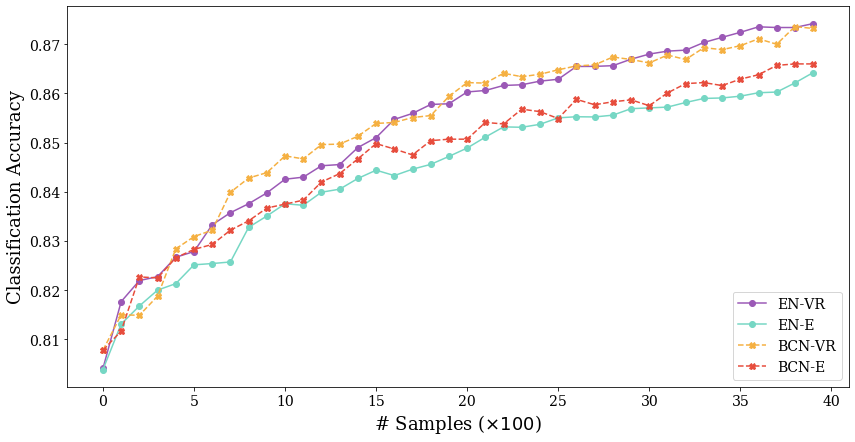

In [27]:
# 1000 initial samples with just 5 NN as active learning instances
pth_1 = "../results_archive/McDropout/ensemble/lenet300-100_fmnist_isample1000_e50_activInstances5_r41_ac1_optim-Adam_top-k100_b32_rtAfter100_variation-ratio/"
pth_2 = "../results_archive/McDropout/ensemble/lenet300-100_fmnist_isample1000_e50_activInstances5_r41_ac1_optim-Adam_top-k100_b32_rtAfter100_entropy/"
pth_3 = '../results_archive/Blenet300-100_fmnist_isample1000_e50_r41_ac1_Klreg-standard2_b100_topK-100_mcmc1_netType-jeffreyoptim-Adam_variation-ratio_rtAfter0/'
pth_4 = '../results_archive/Blenet300-100_fmnist_isample1000_e50_r41_ac1_Klreg-standard2_b100_topK-100_mcmc1_netType-jeffreyoptim-Adam_entropy_rtAfter0/'
locs = [pth_1, pth_2, pth_3, pth_4]
labels = ["EN-VR","EN-E",'BCN-VR','BCN-E']
f_name = 'fig_g'
PlotGraph(f_name,locs,labels,isample=100)

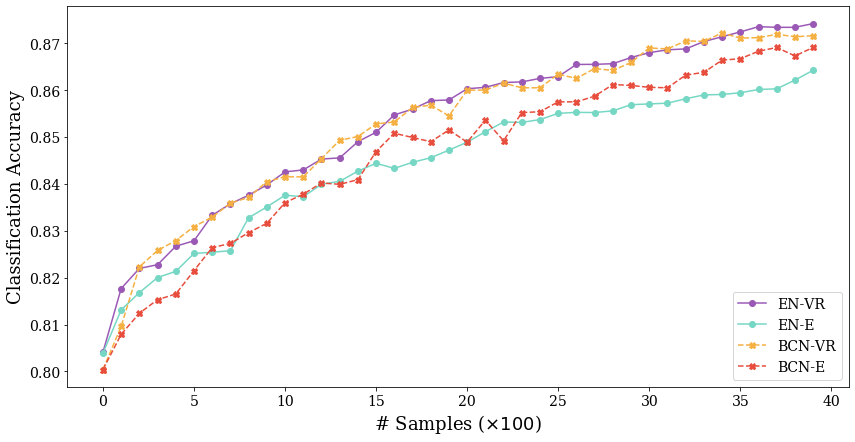

In [26]:
# 1000 initial samples with 25 NN as active learning instances
pth_1 = "../results_archive/McDropout/ensemble/lenet300-100_fmnist_isample1000_e50_activInstances5_r41_ac1_optim-Adam_top-k100_b32_rtAfter100_variation-ratio/"
pth_2 = "../results_archive/McDropout/ensemble/lenet300-100_fmnist_isample1000_e50_activInstances5_r41_ac1_optim-Adam_top-k100_b32_rtAfter100_entropy/"
pth_3 = '../results_archive/Blenet300-100_fmnist_isample1000_e50_r41_ac1_Klreg-standard2_b100_topK-100_mcmc1_activInstances25_netType-jeffreyoptim-Adam_variation-ratio_rtAfter0/'
pth_4 = '../results_archive/Blenet300-100_fmnist_isample1000_e50_r41_ac1_Klreg-standard2_b100_topK-100_mcmc1_activInstances25_netType-jeffreyoptim-Adam_entropy_rtAfter0/'
locs = [pth_1, pth_2, pth_3, pth_4]
labels = ["EN-VR","EN-E",'BCN-VR','BCN-E']
f_name = 'fig_g'
PlotGraph(f_name,locs,labels,isample=100)

2020-05-18 16:30:56 
<h1 align="center"> <a href="https://engmrk.com/lenet-5-a-classic-cnn-architecture/"> Bayesian Lenet 5 - Jeffrey's Prior </a></h1>
The architecture is as follows (for bayesian NN simply double the number of parameters):
<img src="architectures/lenet5_architecture.png" width=600 height=600 />

<p> For all the convolution NN architecture, we follow the following works. Unlike the dense models, here we have a closed form for KL. Additionally, instead of using scale-mixture prior, here we use Jeffrey's prior. </p>

We followed the implementation that was proposed by the following papers:
<ol>
<li> Kingma, Diederik P., Tim Salimans, and Max Welling. "Variational dropout and the local reparameterization trick." NIPS (2015). </li>
<li> Molchanov, Dmitry, Arsenii Ashukha, and Dmitry Vetrov. "Variational Dropout Sparsifies Deep Neural Networks." ICML (2017). </li>
<li> Louizos, Christos, Karen Ullrich, and Max Welling. "Bayesian Compression for Deep Learning." NIPS (2017).</li>
</ol>
<p> The KL divergence was implemented according to [3] Eq.(8), while the approximation of KL was performed based on [2] Eq.(14)</p>

2020-05-18 16:41:06 

<font size="3" color="blue"><b> Exprimental Setting for Bayesian NN </b></font>
    <li><b>Batch size</b>: 100</li>
    <li><b>KL scaling factor: </b>$\frac{1}{\#SamplesPerRound}$. This is according to [3]</li>
    <li><b>Retraining Methodology:</b> Unlike the CVPR paper, <b>we do not retrain from scratch</b>. We found that this method is mostly <b>detrimental to the performance </b> of all models (Both Bayesian and Non-bayesian). At each round, we simply re-use the previous weights, and train the model for a significantly less number of epoch. More precisely, We allot 10% of the training data as validation set and use an early stopping technique, to get the best parameters based on this validation set.</li>
    <li><b>Number of MCMC samples</b>: 1 <b>Note:</b>Since we have a closed form solution, we don't do MCMC to approximate KL. This significantly speeds up the execution time.</li>
    <li><b>Optimization Algorithm</b>: Adam</li>
    <li><b>Number of NN instantiations</b>: 25. That is, when performing active learning, we create 25 instantiations of NN with dropout and estimate variation-ratio and entropy.</li>
    
    
<font size="3" color="blue"><b> Exprimental Setting for Dropout neural network (NN)</b></font>
<li><b>Batch Size</b>: 32</li>
<li> <b>Dropout Rate</b>: 0.5 for the last 3 dense layers and 0.25 for the convolution layers</li>
<li><b>Retraining Methodology:</b> Unlike the CVPR paper, <b>we do not retrain from scratch</b>. We found that this method is mostly <b>detrimental to the performance </b> of all models (Both Bayesian and Non-bayesian). At each round, we simply re-use the previous weights, and train the model for a significantly less number of epoch. More precisely, We allot 10% of the training data as validation set and use an early stopping technique, to get the best parameters based on this validation set.</li>
<li><b>Optimization Algorithm</b>: Adam</li>
<li><b>Number of NN instantiations</b>: 25. That is, when performing active learning, we create 25 instantiations of NN with dropout and estimate variation-ratio and entropy.</li>
The legend used in the graph are as follows:
AL stands for <u>a</u>ctive <u>l</u>earning with dropout-based neural network, <font color="blue">AL-VR</font> stands for <b><u>a</u>ctive <u>l</u>earning using <u>v</u>ariation-<u>r</u>atio</b>, <font color="blue">AL-E</font> stands for <u>a</u>ctive <u>l</u>earning using <u>E</u>ntropy, RS stands for <u>r</u>andom <u>s</u>ampling, legends with the character <font color="blue">B</font> in front of them are the Bayesian couter parts of the variational-ratio and entropy active-learning algorithms respectively.

</p>

<h4 align="center">Add MNIST data</h4>

<h4 align="center">Fashion MNIST data</h4>

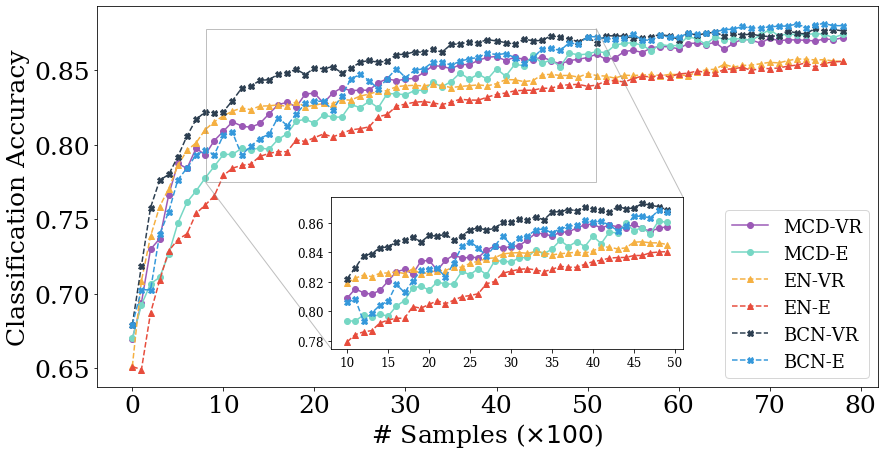

In [10]:
# with 50 samples 2020-10-26 12:59:00 
# MCD
pth_1 = '../results_archive/McDropout/lenet5_fmnist_isample50_e50_r81_ac1_optim-Adam_top-k100_b32_rtAfter100_variation-ratio/'
pth_2 = '../results_archive/McDropout/lenet5_fmnist_isample50_e50_r81_ac1_optim-Adam_top-k100_b32_rtAfter100_entropy/'
#EN
pth_3 = '../results_archive/McDropout/ensemble/lenet5_fmnist_isample50_e50_activInstances5_r80_ac1_optim-Adam_top-k100_b32_rtAfter100_variation-ratio/'
pth_4 = '../results_archive/McDropout/ensemble/lenet5_fmnist_isample50_e50_activInstances5_r80_ac1_optim-Adam_top-k100_b32_rtAfter100_entropy/'
# BCN
pth_5 = '../results_archive/lenet5_fmnist_isample50_e50_r80_ac1_Klreg-standard2_b100_topK-100_mcmc1__activInstances-25_netType-jeffreyoptim-Adam_variation-ratio_rtAfter0/'
pth_6 = '../results_archive/lenet5_fmnist_isample50_e50_r80_ac1_Klreg-standard2_b100_topK-100_mcmc1_activInstances-25_netType-jeffreyoptim-Adam_entropy_rtAfter0/'

locs = [pth_1, pth_2, pth_3, pth_4, pth_5, pth_6]
labels = ['MCD-VR','MCD-E',  "EN-VR","EN-E", 'BCN-VR','BCN-E']
f_name = 'fig_c_v2'
PlotGraph(f_name,locs,labels, truncate_end=79, isample=100, mini_window=True, mini_window_range=(10,50))

<h2 align="center"> AlexnetLight (KCNN in CVPR paper) Using Fully Bayesian NN </h2>
<p>
<font size="3">Model Type:<b>Alexnet</b> program file name <b>TrainSimpleDropout_v2_beta.py</b></font> The best accuracy for a full Alexnet architecture is ~ 78.5%. Using a fully-bayesian NN and active learning we are able to achieve <b> ~ 77.5%, with < 40% of the data </b>.

The architecture is as follows (for bayesian NN simply double the number of parameters):
<img src="architectures/Alexnet_architecture.png" width=600 height=600 />


<font size="3"><b> Exprimental Setting for Bayesian NN</b></font>
    <li> Fully Bayesian NN: We found that as we increase the number of convolution layers, the mixture between a frequentist NN and a bayesian NN does not play well. We start to see severe performance losses, especially in the active learning setting, where we keep appending data samples in each round. Therefore, we used an end-to-end bayesian NN. <b>Note: Unlike the MCMC version of BNN used in other experiments, here I used a closed form version </b></li>
    <li><b>KL scaling factor: </b>$\frac{1}{\# Number of data samples in a round}$. This is <font color="red"> extremely important</font> since changing this will result in wide performance changes. In most cases, I found other Kl scaling factor to be detrimental to MNIST data. In the implementation this is indicated by the variable <i><font color="blue">standard2</font></i>.</li>
    <li><b>Training batch size</b>: 100</li>
    <li><b>Training/Testing Method:</b> Unlike the CVPR paper, <b>we do not retrain from scratch</b>. We found that this method is mostly <b>detrimental to the performance </b> of all models (Both Bayesian and Non-bayesian). At each round, we simply re-use the previous weights, and train the model for a significantly less number of epoch. More precisely, We allot 5% of the training data as validation set and use an early stopping technique, to get the best parameters based on this validation set.</li>
    <li><b>Number of MCMC samples</b>: 1 (due to closed form KL, we just need 1 sample)</li>
    <li><b>Number of NN instantiations</b>: 15. That is, when performing active learning, we create 15 instantiations of NN with dropout and estimate variation-ratio and entropy.</li>
    <li><b>Optimization Algorithm</b>: SGD. lr= 0.001, momentum=0.9<b> Note: I found that using Adam optimization leads to sub-optimal results. Specifically, I found that after adding new data samples in each round, the model gets trapped in some local optimum and struggles to move forward. This however does not seem to be a problem when using the entire dataset.</b></li>

<font size="3"><b> Exprimental Setting for Dropout neural network (NN)</b></font>
<li>Batch Size: 32</li>
<li> <b>Dropout Rate</b>: 0.5 for the last 3 dense layers and 0.25 for the convolution layers</li>
<li> <b># Batchs Per-Round</b>:In each round, we add 500 samples (when compared to just 100 in MNIST and FMNIST)</li>
<li><b>Training Methodology</b>:We retrain the model from scratch after <b> each round </b></li>
<li><b>Optimization Algorithm</b>: SGD. lr= 0.001, momentum=0.9<b> Note: I found that using Adam optimization leads to sub-optimal results. Specifically, I found that after adding new data samples in each round, the model gets trapped in some local optimum and struggles to move forward. This however does not seem to be a problem when using the entire dataset.</b></li>
<li><b>Number of NN instantiations</b>: 15. That is, when performing active learning, we create 15 instantiations of NN with dropout and estimate variation-ratio and entropy.</li>
<li>At each round we randomly allocate 10% of the training data as validation. We adopt an early stopping criteria, where we choose the parameters that result in the best accuracy for this validation set.</li>
The legend used in the graph are as follows:
AL stands for <u>a</u>ctive <u>l</u>earning with dropout-based neural network, <font color="blue">AL-VR</font> stands for <b><u>a</u>ctive <u>l</u>earning using <u>v</u>ariation-<u>r</u>atio</b>, <font color="blue">AL-E</font> stands for <u>a</u>ctive <u>l</u>earning using <u>E</u>ntropy, RS stands for <u>r</u>andom <u>s</u>ampling, legends with the character <font color="blue">B</font> in front of them are the Bayesian couter parts of the variational-ratio and entropy active-learning algorithms respectively. <font color="blue">F</font> in front of them stands for Fully Bayesian (i.e., end-to-end) architectures.

All the results were obtained with an ensemble 15 instantiations of NN. The graphs here are the average prediction accuracies. 
</p>

<h4 align="center"> Cifar10 Dataset </h4>

<h4> Ensemble Vs Bayesian </h4>

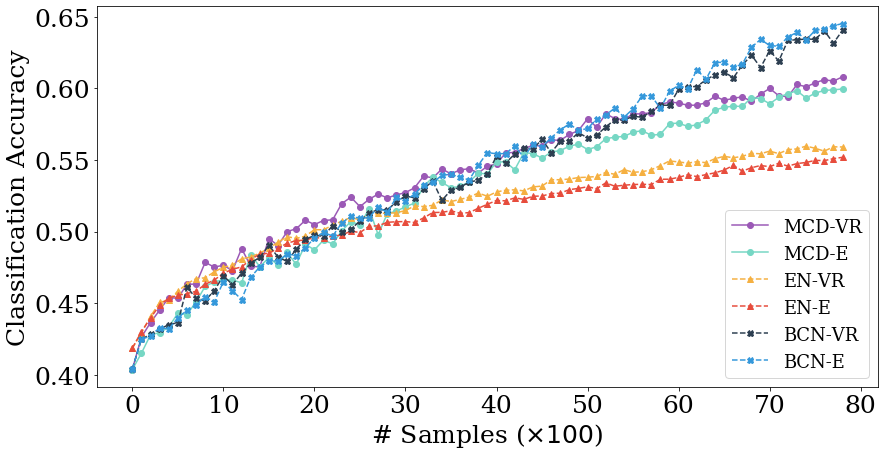

In [31]:
# with 50 samples 2020-10-26 14:34:23 
# MCD
pth_1 = '../results_archive/alexnetlight_cifar10_isample1000_e50_r81_ac1_Klreg-standard2_b256_topK-250_mcmc_1activInstances25_netType-jeffreyoptim-Adam_variation-ratio_rtAfter0/'
pth_2 = '../results_archive/alexnetlight_cifar10_isample1000_e50_r81_ac1_Klreg-standard2_b256_topK-250_mcmc_1activInstances25_netType-jeffreyoptim-Adam_entropy_rtAfter0/'
#EN
pth_3 = '../results_archive/McDropout/ensemble/alexnetlight_cifar10_isample1000_e50_activInstances5_r81_ac1_optim-Adam_top-k250_b256_rtAfter0_variation-ratio/'
pth_4 = '../results_archive/McDropout/ensemble/alexnetlight_cifar10_isample1000_e50_activInstances5_r81_ac1_optim-Adam_top-k250_b256_rtAfter0_entropy/'
# BCN

pth_5 = '../results_archive/McDropout/alexnetlight_cifar10_isample1000_e50_activInstances25_r81_ac1_optim-Adam_top-k250_b256_rtAfter0_variation-ratio/'
pth_6 = '../results_archive/McDropout/alexnetlight_cifar10_isample1000_e50_activInstances25_r81_ac1_optim-Adam_top-k250_b256_rtAfter0_entropy/'

locs = [pth_1, pth_2, pth_3, pth_4, pth_5, pth_6]
labels = ['MCD-VR','MCD-E',  "EN-VR","EN-E", 'BCN-VR','BCN-E']
f_name = 'alexnetlight_cifar10_rt0'
PlotGraph(f_name,locs,labels, truncate_end=79, isample=100)

<h3 align="center"> Retraining from Scratch </h3>

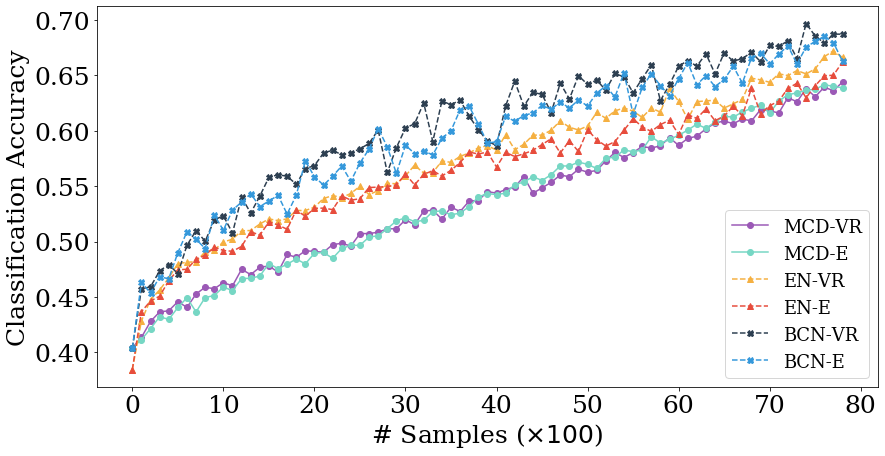

In [32]:
# 2020-11-03 23:58:32 
# MCD
pth_1 = '../results_archive/McDropout/alexnetlight_cifar10_isample1000_e50_activInstances25_r81_ac1_optim-Adam_top-k250_b256_rtAfter1_variation-ratio/'
pth_2 = '../results_archive/McDropout/alexnetlight_cifar10_isample1000_e50_activInstances25_r81_ac1_optim-Adam_top-k250_b256_rtAfter1_entropy/'
#EN
pth_3 = '../results_archive/McDropout/ensemble/alexnetlight_cifar10_isample1000_e50_activInstances5_r81_ac1_optim-Adam_top-k250_b256_rtAfter1_variation-ratio/'
pth_4 = '../results_archive/McDropout/ensemble/alexnetlight_cifar10_isample1000_e50_activInstances5_r81_ac1_optim-Adam_top-k250_b256_rtAfter1_entropy/'
# BCN
pth_5 = '../results_archive/alexnetlight_cifar10_isample1000_e50_r81_ac1_Klreg-standard2_b256_topK-250_mcmc_1activInstances25_netType-jeffreyoptim-Adam_variation-ratio_rtAfter1/'
pth_6 = '../results_archive/alexnetlight_cifar10_isample1000_e50_r81_ac1_Klreg-standard2_b256_topK-250_mcmc_1activInstances25_netType-jeffreyoptim-Adam_entropy_rtAfter1/'

locs = [pth_1, pth_2, pth_3, pth_4, pth_5, pth_6]
labels = ['MCD-VR','MCD-E',  "EN-VR","EN-E", 'BCN-VR','BCN-E']
f_name = 'alexnetlight_cifar10_rt1'
PlotGraph(f_name,locs,labels, truncate_end=79, isample=100)

<h3 align="center"> ECE for No Retrain and Retrain from Scratch</h3>

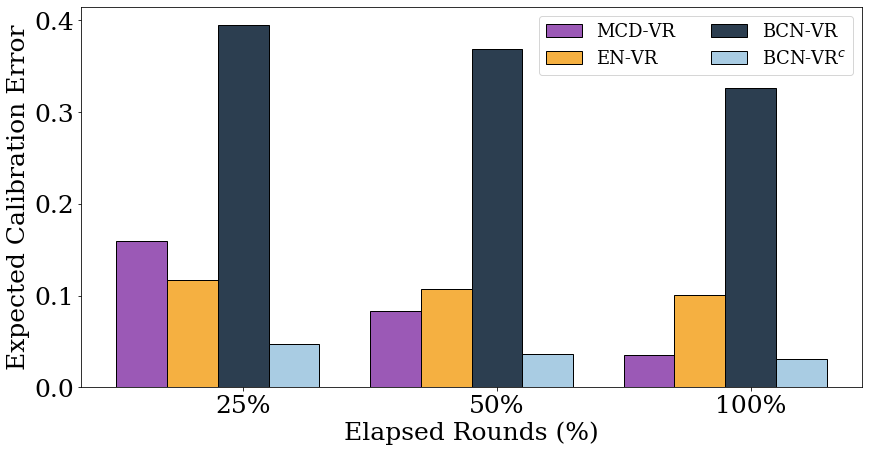

In [38]:
#EN
pth_1 = '../results_archive/McDropout/alexnetlight_cifar10_isample1000_e50_activInstances25_r81_ac1_optim-Adam_top-k250_b256_rtAfter0_variation-ratio/'
#EN
pth_2 = '../results_archive/McDropout/ensemble/alexnetlight_cifar10_isample1000_e50_activInstances5_r81_ac1_optim-Adam_top-k250_b256_rtAfter0_variation-ratio/'
# BCN
pth_3 = '../results_archive/alexnetlight_cifar10_isample1000_e50_r81_ac1_Klreg-standard2_b256_topK-250_mcmc_1activInstances25_netType-jeffreyoptim-Adam_variation-ratio_rtAfter0/'
pth_4 = '../results_archive/alexnetlight_cifar10_isample1000_e50_r81_ac1_Klreg-standard2_b256_topK-250_mcmc_1activInstances25_netType-jeffreyoptim-Adam_variation-ratio_rtAfter0/'
locs = [pth_1, pth_2, pth_3, pth_4]
x_tick_labels=['25%','50%','100%'] # 'names for each group of plots.'
x_label = "Elapsed Rounds (%)"
y_label = "Expected Calibration Error"
legend_names = ['MCD-VR', 'EN-VR', 'BCN-VR','BCN-VR$^c$']
figure_name = "ece_alexnetlight_cifar10_rt0"
bar_plot(data_locs=locs, metric="ece", calib_ece_loc=3, x_tick_labels=x_tick_labels, truncate_end=80,
         x_label=x_label, y_label=y_label, legend_names=legend_names, n_legen_clmns=2, figure_nam=figure_name)

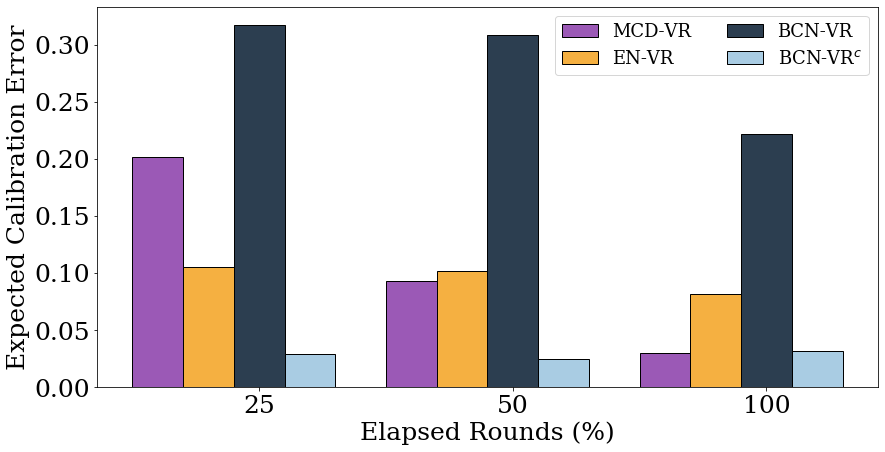

In [39]:
#EN
pth_1 = '../results_archive/McDropout/alexnetlight_cifar10_isample1000_e50_activInstances25_r81_ac1_optim-Adam_top-k250_b256_rtAfter1_variation-ratio/'
#EN
pth_2 = '../results_archive/McDropout/ensemble/alexnetlight_cifar10_isample1000_e50_activInstances5_r81_ac1_optim-Adam_top-k250_b256_rtAfter1_variation-ratio/'
# BCN
pth_3 = '../results_archive/alexnetlight_cifar10_isample1000_e50_r81_ac1_Klreg-standard2_b256_topK-250_mcmc_1activInstances25_netType-jeffreyoptim-Adam_variation-ratio_rtAfter1/'
pth_4 = '../results_archive/alexnetlight_cifar10_isample1000_e50_r81_ac1_Klreg-standard2_b256_topK-250_mcmc_1activInstances25_netType-jeffreyoptim-Adam_variation-ratio_rtAfter1/'
locs = [pth_1, pth_2, pth_3, pth_4]
x_tick_labels=['25','50','100'] # 'names for each group of plots.'
x_label = "Elapsed Rounds (%)"
y_label = "Expected Calibration Error"
legend_names = ['MCD-VR', 'EN-VR', 'BCN-VR','BCN-VR$^c$']
figure_name = "ece_alexnetlight_cifar10_rt1"
bar_plot(data_locs=locs, metric="ece", calib_ece_loc=3, x_tick_labels=x_tick_labels, truncate_end=80,
         x_label=x_label, y_label=y_label, legend_names=legend_names, n_legen_clmns=2, figure_nam=figure_name)

2020-05-05 21:07:20 
<h2 align="center"> VGG19 Using Fully Bayesian NN </h2>

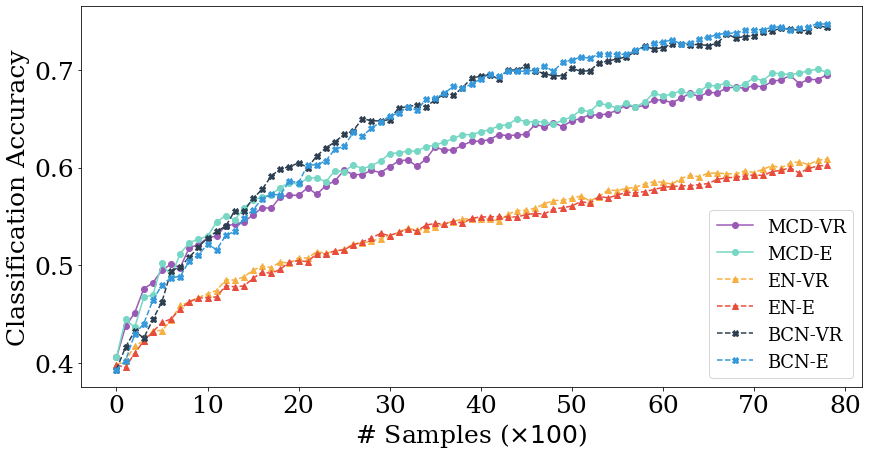

In [40]:
# MCD
pth_1 = '../results_archive/McDropout/vgg_cifar10_isample1000_e50_activInstances15_r81_ac1_optim-Adam_top-k250_b100_rtAfter0_variation-ratio/'
pth_2 = '../results_archive/McDropout/vgg_cifar10_isample1000_e50_activInstances15_r81_ac1_optim-Adam_top-k250_b100_rtAfter0_entropy/'
#EN
pth_3 = '../results_archive/McDropout/ensemble/vgg_cifar10_isample1000_e50_activInstances5_r81_ac1_optim-Adam_top-k250_b256_rtAfter0_variation-ratio/'
pth_4 = '../results_archive/McDropout/ensemble/vgg_cifar10_isample1000_e50_activInstances5_r81_ac1_optim-Adam_top-k250_b256_rtAfter0_entropy/'
# BCN
pth_5 = '../results_archive/vgg_cifar10_isample1000_e50_r81_ac1_Klreg-standard2_b256_topK-250_mcmc_1activInstances15_netType-jeffreyoptim-Adam_variation-ratio_rtAfter0/'
pth_6 = '../results_archive/vgg_cifar10_isample1000_e50_r81_ac1_Klreg-standard2_b256_topK-250_mcmc_1activInstances15_netType-jeffreyoptim-Adam_entropy_rtAfter0/'

locs = [pth_1, pth_2, pth_3, pth_4, pth_5, pth_6]
labels = ['MCD-VR','MCD-E',  "EN-VR","EN-E", 'BCN-VR','BCN-E']
f_name = 'vgg_cifar10_rt0'
PlotGraph(f_name,locs,labels, truncate_end=79, isample=100)

<h3 align="center"> Retraining from Scratch </h3>

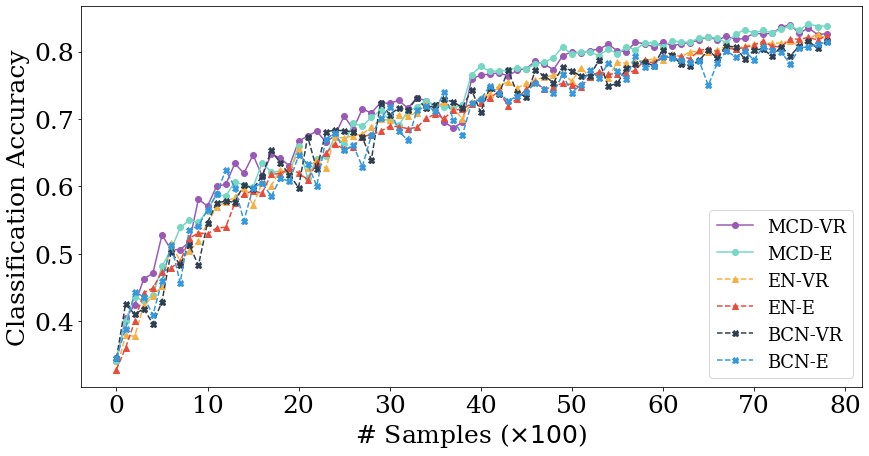

In [41]:
# 2020-11-04 11:32:58 
pth_1 = '../results_archive/McDropout/vgg_cifar10_isample1000_e50_activInstances15_r81_ac1_optim-Adam_top-k250_b256_rtAfter1_variation-ratio/'
pth_2 = '../results_archive/McDropout/vgg_cifar10_isample1000_e50_activInstances15_r81_ac1_optim-Adam_top-k250_b256_rtAfter1_entropy/'

pth_3 = '../results_archive/McDropout/ensemble/vgg_cifar10_isample1000_e50_activInstances5_r81_ac1_optim-Adam_top-k250_b256_rtAfter1_variation-ratio/'
pth_4 = '../results_archive/McDropout/ensemble/vgg_cifar10_isample1000_e50_activInstances5_r81_ac1_optim-Adam_top-k250_b256_rtAfter1_entropy/'

pth_5 = '../results_archive/vgg_cifar10_isample1000_e50_r81_ac1_Klreg-standard2_b256_topK-250_mcmc_1activInstances15_netType-jeffreyoptim-Adam_variation-ratio_rtAfter1/'
pth_6 = '../results_archive/vgg_cifar10_isample1000_e50_r81_ac1_Klreg-standard2_b256_topK-250_mcmc_1activInstances15_netType-jeffreyoptim-Adam_entropy_rtAfter1/'

locs = [pth_1, pth_2, pth_3, pth_4, pth_5, pth_6]
labels = ['MCD-VR','MCD-E',  "EN-VR","EN-E", 'BCN-VR','BCN-E']
f_name = 'vgg_cifar10_rt1'
PlotGraph(f_name,locs,labels, truncate_end=79, isample=100)

<h3 align="center"> ECE for No Retrain and Retrain from Scratch</h3>

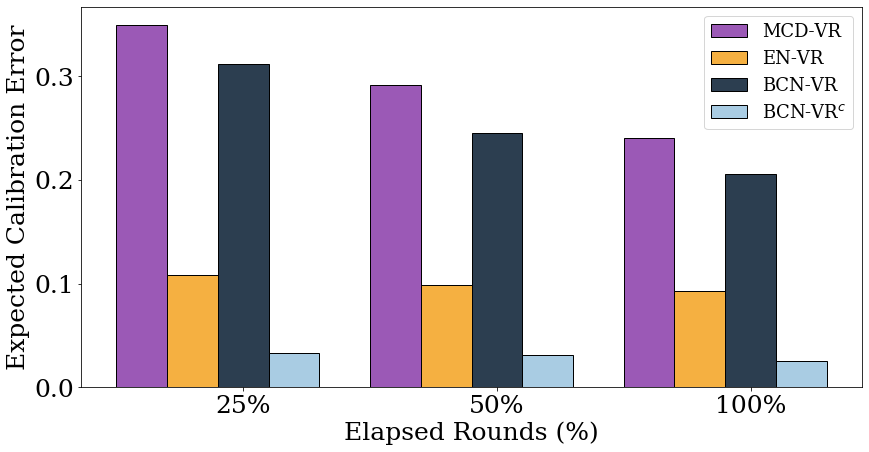

In [43]:
#EN
pth_1 = '../results_archive/McDropout/vgg_cifar10_isample1000_e50_activInstances15_r81_ac1_optim-Adam_top-k250_b100_rtAfter0_variation-ratio/'
#EN
pth_2 = '../results_archive/McDropout/ensemble/vgg_cifar10_isample1000_e50_activInstances5_r81_ac1_optim-Adam_top-k250_b256_rtAfter0_variation-ratio/'
# BCN
pth_3 = '../results_archive/vgg_cifar10_isample1000_e50_r81_ac1_Klreg-standard2_b256_topK-250_mcmc_1activInstances15_netType-jeffreyoptim-Adam_variation-ratio_rtAfter0/'
pth_4 = '../results_archive/vgg_cifar10_isample1000_e50_r81_ac1_Klreg-standard2_b256_topK-250_mcmc_1activInstances15_netType-jeffreyoptim-Adam_variation-ratio_rtAfter0/'
locs = [pth_1, pth_2, pth_3, pth_4]
x_tick_labels=['25%','50%','100%'] # 'names for each group of plots.'
x_label = "Elapsed Rounds (%)"
y_label = "Expected Calibration Error"
legend_names = ['MCD-VR', 'EN-VR', 'BCN-VR','BCN-VR$^c$']
figure_name = "ece_vgg_cifar10_rt0"
bar_plot(data_locs=locs, metric="ece", calib_ece_loc=3, x_tick_labels=x_tick_labels, truncate_end=80,
         x_label=x_label, y_label=y_label, legend_names=legend_names, figure_nam=figure_name)

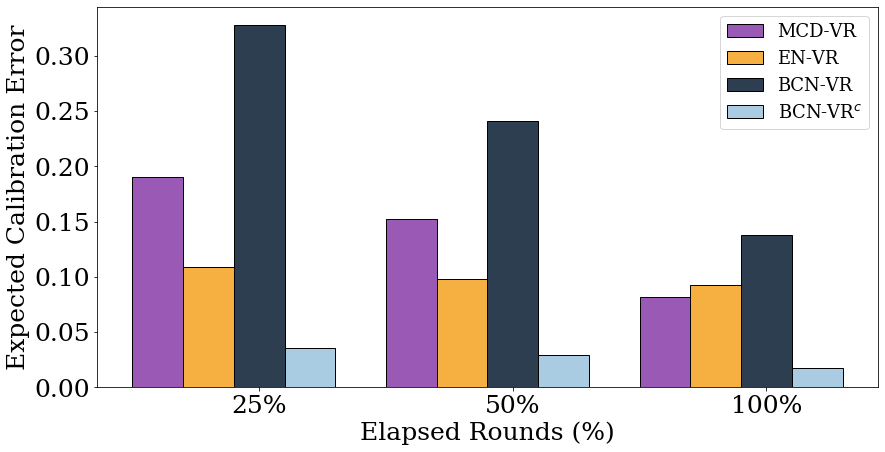

In [44]:
#EN
pth_1 = '../results_archive/McDropout/vgg_cifar10_isample1000_e50_activInstances15_r81_ac1_optim-Adam_top-k250_b256_rtAfter1_variation-ratio/'
#EN
pth_3 = '../results_archive/McDropout/ensemble/vgg_cifar10_isample1000_e50_activInstances5_r81_ac1_optim-Adam_top-k250_b256_rtAfter1_variation-ratio/'
# BCN
pth_3 = '../results_archive/vgg_cifar10_isample1000_e50_r81_ac1_Klreg-standard2_b256_topK-250_mcmc_1activInstances15_netType-jeffreyoptim-Adam_variation-ratio_rtAfter1/'
pth_4 = '../results_archive/vgg_cifar10_isample1000_e50_r81_ac1_Klreg-standard2_b256_topK-250_mcmc_1activInstances15_netType-jeffreyoptim-Adam_variation-ratio_rtAfter1/'
locs = [pth_1, pth_2, pth_3, pth_4]
x_tick_labels=['25%','50%','100%'] # 'names for each group of plots.'
x_label = "Elapsed Rounds (%)"
y_label = "Expected Calibration Error"
legend_names = ['MCD-VR', 'EN-VR', 'BCN-VR','BCN-VR$^c$']
figure_name = "ece_vgg_cifar10_rt1"
bar_plot(data_locs=locs, metric="ece", calib_ece_loc=3, x_tick_labels=x_tick_labels, truncate_end=80,
         x_label=x_label, y_label=y_label, legend_names=legend_names, figure_nam=figure_name)

2020-10-05 09:50:49 
<h2 align="center"> Densenets on CIFAR100 Using Fully Bayesian NN </h2>

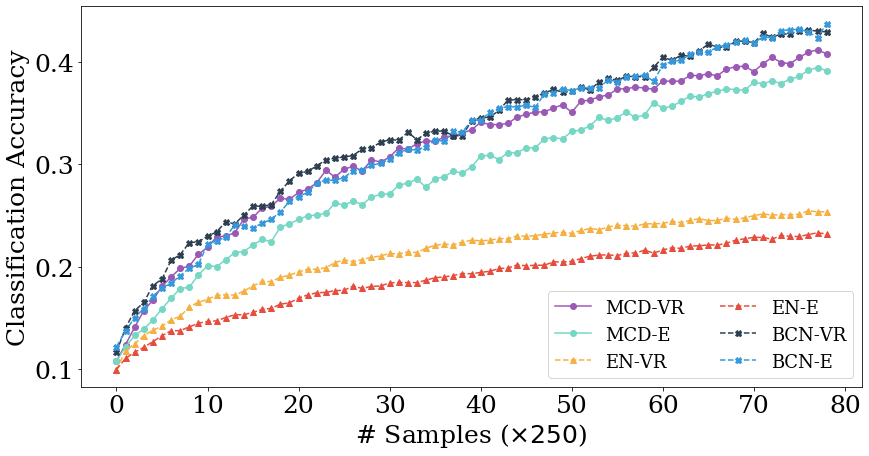

In [46]:
#2020-10-05 17:02:59 
pth_1 = '../results_archive/McDropout/densenet_cifar100_isample1000_e50_activInstances15_r81_ac1_optim-Adam_top-k250_b64_rtAfter0_variation-ratio/'
pth_2 = '../results_archive/McDropout/densenet_cifar100_isample1000_e50_activInstances15_r81_ac1_optim-Adam_top-k250_b64_rtAfter0_entropy/'

pth_3 = '../results_archive/McDropout/ensemble/densenet_cifar100_isample1000_e50_activInstances5_r81_ac1_optim-Adam_top-k250_b100_rtAfter100_variation-ratio/'
pth_4 = '../results_archive/McDropout/ensemble/densenet_cifar100_isample1000_e50_activInstances5_r81_ac1_optim-Adam_top-k250_b100_rtAfter100_entropy/'

pth_5 = '../results_archive/densenet_cifar100_isample1000_e50_r81_ac1_Klreg-standard2_b128_topK-250_mcmc_1activInstances15_netType-jeffreyoptim-Adam_variation-ratio_rtAfter0/'
pth_6 = '../results_archive/densenet_cifar100_isample1000_e50_r81_ac1_Klreg-standard2_b128_topK-250_mcmc_1activInstances10_netType-jeffreyoptim-Adam_entropy_rtAfter0/'

locs = [pth_1, pth_2, pth_3, pth_4, pth_5, pth_6]
labels = ['MCD-VR','MCD-E','EN-VR','EN-E','BCN-VR','BCN-E']
f_name = 'densenet_cifar100_rt0'
PlotGraph(f_name,locs,labels,truncate_end=79, n_legen_clmns=2, isample=250)

<h3 align="center"> Retraining from Scratch </h3>

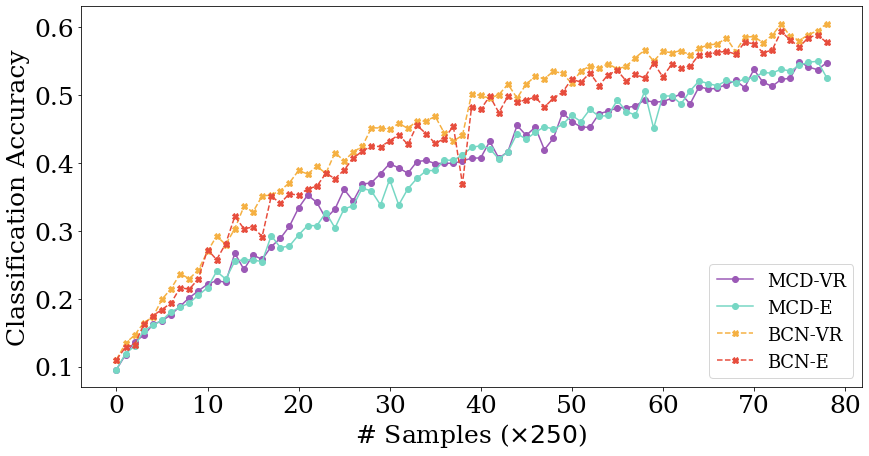

In [49]:
# 2020-11-04 09:36:41 
pth_1 = '../results_archive/McDropout/densenet_cifar100_isample1000_e50_activInstances15_r81_ac1_optim-Adam_top-k250_b100_rtAfter1_variation-ratio/'
pth_2 = '../results_archive/McDropout/densenet_cifar100_isample1000_e50_activInstances15_r81_ac1_optim-Adam_top-k250_b100_rtAfter1_entropy/'

pth_3 = '../results_archive/densenet_cifar100_isample1000_e50_r81_ac1_Klreg-standard2_b256_topK-250_mcmc_1activInstances15_netType-jeffreyoptim-Adam_variation-ratio_rtAfter1/'
pth_4 = '../results_archive/densenet_cifar100_isample1000_e50_r81_ac1_Klreg-standard2_b256_topK-250_mcmc_1activInstances15_netType-jeffreyoptim-Adam_entropy_rtAfter1/'
locs = [pth_1, pth_2, pth_3, pth_4]
labels = ['MCD-VR','MCD-E','BCN-VR','BCN-E']
f_name = 'densenet_cifar100_rt1'
PlotGraph(f_name,locs,labels,truncate_end=79,isample=250)

<b>2020-08-21 09:11:10</b>
<h3 align="center"> Regression Plots</h3>
<font size="3" color="blue"><b> Global Setting </b></font>
<li>Model: Lenet300-100 </li>
<li>Dataset: <b> Boston  Housing </b>. This dataset 506 data points out of which we use 354 for training (70%) and the rest 152 for testing. It has 13 features. The details about this dataset can be found <a href="https://scikit-learn.org/stable/datasets/index.html#boston-dataset"> here</a></li>
<li> <b>Seed sample</b>: 50</li>
<li> <b>Acquisition Size</b>: After each round 5 new samples are added to the training set</li>
<li><b>Uncertainty Measurement</b>: we just use <b> variance </b> as the measurement of uncertainty. For classification we used variation-ratio and entropy. For regression <font color="red">what are the other measurements of uncertainty?</font></li>
<font size="3" color="blue"><b> Exprimental Setting for Bayesian NN (BCN) </b></font>
    <li><b>Batch size</b>: 8</li>
    <li><b>KL scaling factor: </b>$\frac{1}{\#SamplesPerRound}$. This is according to [3]</li>
    <li><b>Retraining Methodology:</b> Unlike the CVPR paper, <b>we do not retrain from scratch</b>. We found that this method is mostly <b>detrimental to the performance </b> of all models (Both Bayesian and Non-bayesian). At each round, we simply re-use the previous weights, and train the model for a significantly less number of epoch. More precisely, We allot 10% of the training data as validation set and use an early stopping technique, to get the best parameters based on this validation set.</li>
    <li><b>Number of MCMC samples</b>: 1 <b>Note:</b>Since we have a closed form solution, we don't do MCMC to approximate KL. This significantly speeds up the execution time.</li>
    <li><b>Optimization Algorithm</b>: Adam</li>
    <li><b>Number of NN instantiations</b>: 500. That is, when performing active learning, we create 500 instantiations and estimate variation-ratio and entropy.</li>

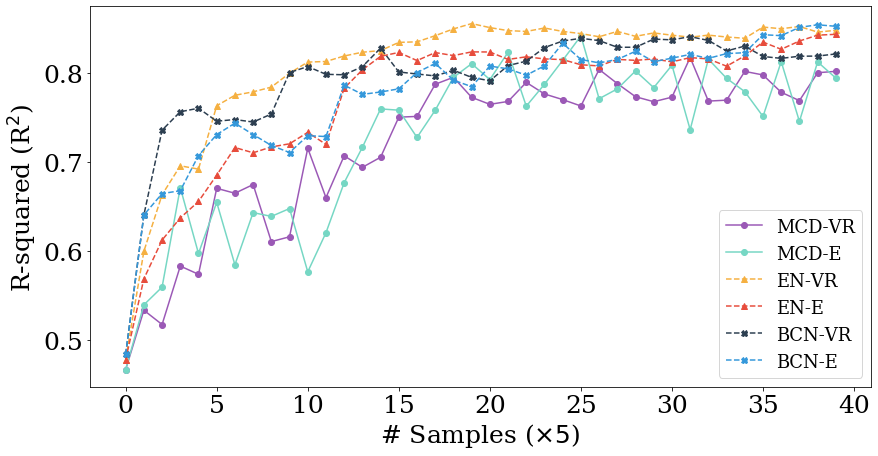

In [30]:
#MCD
pth_1 = '../results/McDropout/lenet300-100_boston_housing_isample50_e50_activInstances25_r41_ac1_optim-Adam_top-k5_b8_rtAfter0_variation-ratio/'
pth_2 = '../results/McDropout/lenet300-100_boston_housing_isample50_e50_activInstances25_r41_ac1_optim-Adam_top-k5_b8_rtAfter0_entropy/'
# EN
pth_3 = '../results/McDropout/ensemble/lenet300-100_boston_housing_isample50_e50_activInstances5_r41_ac1_optim-Adam_top-k5_b32_rtAfter0_variation-ratio/'
pth_4 = '../results/McDropout/ensemble/lenet300-100_boston_housing_isample50_e50_activInstances5_r41_ac1_optim-Adam_top-k5_b32_rtAfter0_entropy/'

#BCN
pth_5 = '../results/Blenet300-100_boston_housing_isample50_e50_r41_ac1_Klreg-standard2_b8_topK-5_mcmc1_netType-jeffreyoptim-Adam_variation-ratio_rtAfter0/'
pth_6 = '../results/Blenet300-100_boston_housing_isample50_e50_r41_ac1_Klreg-standard2_b8_topK-5_mcmc1_netType-jeffreyoptim-Adam_entropy_rtAfter0/'

locs = [pth_1, pth_2, pth_3, pth_4, pth_5, pth_6]
labels = ['MCD-VR','MCD-E', 'EN-VR','EN-E','BCN-VR','BCN-E']
f_name = 'regression_1'
PlotGraph(f_name,locs,labels,metric='r2', isample=5, truncate_end=40)